notebook to compare two pick files for a given track

Brandon S. Tober

24SEP2020

CONDA ENV: py3, wsl

In [1]:
### imports ###
import glob
import pyproj
import plotly.graph_objects as go
import rasterio as rio
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6.5,6.5]
font = {'family' : 'verdana',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# functions
def euclid_dist(xarray, yarray,zarray):
    dist = np.zeros_like(xarray)
    dist[1:] = np.cumsum(np.sqrt(np.diff(xarray) ** 2.0 + np.diff(yarray) ** 2.0 + np.diff(zarray) ** 2.0))
    return dist

In [3]:
# data path
in_path = "G:/MARS/targ/supl/UAF/radar/2021/pick/"
flist = glob.glob(in_path + "*.csv")
print(flist)

['G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-212349_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-212923_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-214008_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-220352_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-220708_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-221323_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-222134_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-223515_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210502-235237_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210503-000556_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210503-002426_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210503-004101_pk_bst.csv', 'G:/MARS/targ/supl/UAF/radar/2021/pick\\IRARES1B_20210503-00563

In [4]:
# file names
f0 = in_path + "IRARES1B_20210503-011452_pk_bst.csv"
f1 = in_path + "IRARES1B_20210502-223515_pk_bst.csv"
f2 = in_path + "IRARES1B_20210503-000556_pk_bst.csv"
# f0 = flist[0] # 20170815-223239
# f1 = flist[1] # 20210505-214305
# f2 = flist[2] # 20210505-232812

In [5]:
# read in each file
dat0 = pd.read_csv(f0,delimiter=",",index_col=False,header=0)
# ensure proper indexing
dat0 = dat0.sort_values(by=['trace'])
dat0 = dat0.reset_index()

dat1 = pd.read_csv(f1,delimiter=",",index_col=False,header=0)
# ensure proper indexing
dat1 = dat1.sort_values(by=['trace'])
dat1 = dat1.reset_index()

dat2 = pd.read_csv(f2,delimiter=",",index_col=False,header=0)
# ensure proper indexing
dat2 = dat2.sort_values(by=['trace'])
dat2 = dat2.reset_index()

In [6]:
# inspect df
dat0

,index,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_elev,bed_amp,srf_bed_thick
0,0,0,-140.179789,60.025861,599.08645,159.0,0.000002,360.751444,2.381244,NaN,NaN,NaN,NaN,NaN
1,1,1,-140.179746,60.025855,599.10090,159.0,0.000002,360.765894,2.468691,NaN,NaN,NaN,NaN,NaN
2,2,2,-140.179702,60.025849,599.11180,159.0,0.000002,360.776794,2.581199,NaN,NaN,NaN,NaN,NaN
3,3,3,-140.179659,60.025843,599.12445,159.0,0.000002,360.789444,2.708102,NaN,NaN,NaN,NaN,NaN
4,4,4,-140.179616,60.025837,599.13690,159.0,0.000002,360.801894,2.856011,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172,12172,12172,-140.661422,60.116825,661.75715,128.0,0.000001,469.889978,0.958142,NaN,NaN,NaN,NaN,NaN
12173,12173,12173,-140.661415,60.116801,661.78670,128.0,0.000001,469.919528,0.893884,NaN,NaN,NaN,NaN,NaN
12174,12174,12174,-140.661409,60.116777,661.81725,128.0,0.000001,469.950078,0.836248,NaN,NaN,NaN,NaN,NaN
12175,12175,12175,-140.661402,60.116753,661.84515,128.0,0.000001,469.977978,0.776773,NaN,NaN,NaN,NaN,NaN


In [7]:
dat0 = dat0.reindex(index=dat0.index[::-1])

In [8]:
dat0

,index,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_elev,bed_amp,srf_bed_thick
12176,12176,12176,-140.661395,60.116729,661.87370,128.0,0.000001,470.006528,0.736462,NaN,NaN,NaN,NaN,NaN
12175,12175,12175,-140.661402,60.116753,661.84515,128.0,0.000001,469.977978,0.776773,NaN,NaN,NaN,NaN,NaN
12174,12174,12174,-140.661409,60.116777,661.81725,128.0,0.000001,469.950078,0.836248,NaN,NaN,NaN,NaN,NaN
12173,12173,12173,-140.661415,60.116801,661.78670,128.0,0.000001,469.919528,0.893884,NaN,NaN,NaN,NaN,NaN
12172,12172,12172,-140.661422,60.116825,661.75715,128.0,0.000001,469.889978,0.958142,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,4,-140.179616,60.025837,599.13690,159.0,0.000002,360.801894,2.856011,NaN,NaN,NaN,NaN,NaN
3,3,3,-140.179659,60.025843,599.12445,159.0,0.000002,360.789444,2.708102,NaN,NaN,NaN,NaN,NaN
2,2,2,-140.179702,60.025849,599.11180,159.0,0.000002,360.776794,2.581199,NaN,NaN,NaN,NaN,NaN
1,1,1,-140.179746,60.025855,599.10090,159.0,0.000002,360.765894,2.468691,NaN,NaN,NaN,NaN,NaN


In [9]:
# get distance for throat crossing flux gate
lon = dat0["lon"].to_numpy()
lat = dat0["lat"].to_numpy()
elev = dat0["elev"].to_numpy()
x, y, z = pyproj.transform(
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
    "+proj=geocent +a=6378140 +b=6356750 +no_defs",
    lon,
    lat,
    elev,
)
dist = euclid_dist(x,y,z)

C:\Users\btobers\.conda\envs\jupyter\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



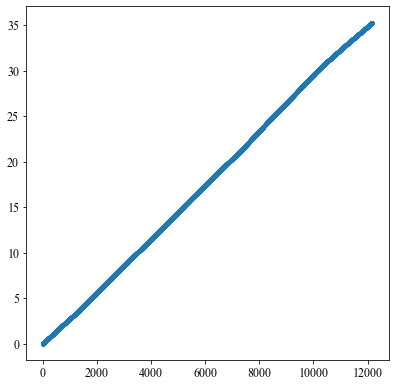

In [10]:
plt.plot(dist*1e-3,'.')

In [31]:
# # need to get a measure of along-track distance for x-axis
# # plot goes NW to SE, so starts with track 21, then ends with track 26 (track 26 is flipped direction)
# # use full length of 21, and trace 0-263 of track 26

# # concatenate lat,long,alt arrays of track 21 with end of track 26
# lon0 = dat0["lon"].to_numpy()
# lat0 = dat0["lat"].to_numpy()
# alt0 = dat0["alt"].to_numpy()

# lon1 = dat1["lon"].to_numpy()
# lat1 = dat1["lat"].to_numpy()
# alt1 = dat1["alt"].to_numpy()

# lon2 = dat2["lon"].to_numpy()[:264]
# lat2 = dat2["lat"].to_numpy()[:264]
# alt2 = dat2["alt"].to_numpy()[:264]

# lon = np.concatenate([lon1,lon2[::-1]])
# lat = np.concatenate([lat1,lat2[::-1]])
# alt = np.concatenate([alt1,alt2[::-1]])

# x, y, z = pyproj.transform(
#     "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
#     "+proj=geocent +a=6378140 +b=6356750 +no_defs",
#     lon,
#     lat,
#     alt,
# )
# dist = euclid_dist(x,y,z)

In [32]:
# plt.plot(dist,'.')
# plt.show()

In [33]:
# # plot
# fig, ax = plt.subplots(1,1)
# ax.plot(np.nan,np.nan,":", color="black",label="21",linewidth=1)
# ax.plot(np.nan,np.nan,"--", color="black",label="26",linewidth=1)
# ax.plot(dat1["gndElev_g12b"], "c:" ,linewidth=1)
# ax.plot(dat1["subsrfElev_g12b"], "g:", linewidth=1)
# ax.plot(np.append(np.repeat(np.nan,620),dat2["gndElev_g12b"].values[::-1]), "c--",linewidth=1)
# ax.plot(np.append(np.repeat(np.nan,620),dat2["subsrfElev_g12b"].values[::-1]), "g--", linewidth=1)

# secaxx = ax.twiny()
# secaxx.xaxis.set_ticks_position("bottom")
# secaxx.xaxis.set_label_position("bottom")
# secaxx.set_xlabel("along-track distance [km]")
# secaxx.set_xlim(0, dist[-1]*1e-3)
# ax.axes.get_xaxis().set_visible(False)
# ax.set_ylabel("elevation [m]")
# ax.legend(loc="lower right",fancybox=True, framealpha=0,ncol=1,handletextpad=0.1)


In [11]:
# # open raster basemap
# with rio.open("C:/Users/btobers/Desktop/OIB-AK_bm_4326.tif", mode="r") as dataset:
#     data = dataset.read(out_shape=(dataset.count, int(dataset.height // 1), int(dataset.width // 1)),
#                         resampling=rio.enums.Resampling.nearest)
#     bmcrs = dataset.crs
#     # stack bands into numpy array
#     im = np.dstack((data))
#     if im.shape[-1] == 1:
#         im = im.reshape(im.shape[0], -1)
#     cmin = np.nanmin(im)
#     cmax = np.nanmax(im)

In [12]:
bed = dat0.bed_elev.to_numpy()[1000:8000]
srf = dat0.srf_elev.to_numpy()[1000:8000]
lon = dat0.lon.to_numpy()[1000:8000]
lat = dat0.lat.to_numpy()[1000:8000]
lon_filt = lon[~np.isnan(bed)]
lat_filt = lat[~np.isnan(bed)]

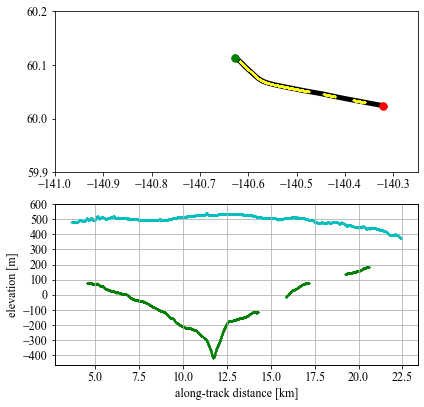

In [13]:
# plot
fig, ax = plt.subplots(2,1)

# bm_im = ax[0].imshow(np.ones((100,100)), aspect="auto")
# bm_im.set_clim([cmin, cmax])
# bm_im.set_data(im)
# bm_im.set_extent([_i for _i in[dataset.bounds.left, dataset.bounds.right,
#                 dataset.bounds.bottom, dataset.bounds.top]])
ax[0].plot(lon,lat,"k",linewidth=5)
ax[0].plot(lon[0],lat[0],"g.",markersize=15)
ax[0].plot(lon[-1],lat[-1],"r.",markersize=15)
ax[0].scatter(lon_filt,lat_filt, c="xkcd:yellow", marker=".",s=.5, zorder=100)
ax[0].set_xlim([-141,-140.25])
ax[0].set_ylim([59.9, 60.2])

ax[1].plot(srf, "c." ,markersize=1)
ax[1].plot(bed, "g.", markersize=1)

secaxx = ax[1].twiny()
secaxx.xaxis.set_ticks_position("bottom")
secaxx.xaxis.set_label_position("bottom")
secaxx.set_xlabel("along-track distance [km]")
secaxx.set_xlim(dist[1000]*1e-3, dist[8000]*1e-3)
ax[1].axes.get_xaxis().set_visible(False)
ax[1].set_ylabel("elevation [m]")
ax[1].set_yticks([-400,-300,-200,-100,0,100,200,300,400,500,600])
ax[1].grid(axis="y")
secaxx.grid(None)

In [158]:
# save fig
fig.savefig("C:/Users/btobers/Documents/pres/mala/figs/2021/" + "seward_throat.png", dpi=300, bbox_inches="tight")

In [15]:
# create 3d plot with plotly
# x0, y0, z0a, z0b = dat0["lon"], dat0["lat"], dat0["srf_elev"], dat0["bed_elev"]
# # x1, y1, z1a, z1b = dat1["lon"], dat1["lat"], dat1["srf_elev"], dat1["bed_elev"]
# # x2, y2, z2a, z2b = dat2["lon"], dat2["lat"], dat2["srf_elev"], dat2["bed_elev"]

# fig = go.Figure(data=[go.Scatter3d(
#     x=x0,
#     y=y0,
#     z=z0a,
#     mode='lines',
#     marker=dict(
#         size=12,
#         color='blue',
#         opacity=1.0),
#     showlegend=False),

#     go.Scatter3d(
#     x=x0,
#     y=y0,
#     z=z0b,
#     mode='lines',
#     marker=dict(
#         size=12,
#         color='chocolate',
#         opacity=1.0),
#     showlegend=False),

#     go.Scatter3d(
#     x=x1,
#     y=y1,
#     z=z1a,
#     mode='lines',
#     marker=dict(
#         size=12,
#         color='blue',
#         opacity=1.0),
#     showlegend=False),

#     go.Scatter3d(
#     x=x1,
#     y=y1,
#     z=z1b,
#     mode='lines',
#     marker=dict(
#         size=12,
#         color='chocolate',
#         opacity=1.0),
#     showlegend=False),

#     go.Scatter3d(
#     x=x2,
#     y=y2,
#     z=z2a,
#     mode='lines',
#     marker=dict(
#         size=8,
#         color='blue',
#         opacity=1.0),
#     showlegend=False),

#     go.Scatter3d(
#     x=x2,
#     y=y2,
#     z=z2b,
#     mode='lines',
#     marker=dict(
#         size=8,
#         color='chocolate',
#         opacity=1.0),
#     showlegend=False),

    # go.Scatter3d(
    # x=np.array(np.nan),
    # y=np.array(np.nan),
    # z=np.array(np.nan),
    # name='20170815-223239',
    # mode='lines',
    # marker=dict(
    #     size=8,
    #     color='black',
    #     opacity=1.0),
    # line=dict(dash='dot')),

    # go.Scatter3d(
    # x=np.array(np.nan),
    # y=np.array(np.nan),
    # z=np.array(np.nan),
    # name='20210505-214305',
    # mode='lines',
    # marker=dict(
    #     size=8,
    #     color='black',
    #     opacity=1.0),
    # line=dict(dash='dash')),

    # go.Scatter3d(
    # x=np.array(np.nan),
    # y=np.array(np.nan),
    # z=np.array(np.nan),
    # name='20210505-232812',
    # mode='lines',
    # marker=dict(
    #     size=8,
    #     color='black',
    #     opacity=1.0),
    # line=dict(dash='dashdot')),
#     ])

# fig.update_layout(scene = dict(
#                     xaxis_title='longitude',
#                     yaxis_title='latitude',
#                     zaxis_title='elevation [m.a.s.l.]'),
#                     font=dict(
#                         family="verdana",
#                         size=12,
#                         color="black"),
#                     margin=dict(l=0, r=0, b=0, t=0),
#                     width=1000, height=500)
# fig.show()

In [17]:
# make 3d surface of plots
# get meshgrid of lat lon
# first get concatenated data arrays
# x = np.array(())
# y = np.array(())
# z = np.array(())

# x = np.concatenate((x,dat0["lon"],dat1["lon"],dat2["lon"]))
# y = np.concatenate((y,dat0["lat"],dat1["lat"],dat2["lat"]))
# z = np.concatenate((z,dat0["bed_elev"],dat1["bed_elev"],dat2["bed_elev"]))

# x_vals = np.linspace(x.min(),x.max(),1000)
# y_vals = np.linspace(y.min(),y.max(),1000)

# xi, yi = np.meshgrid(x_vals,y_vals)
# # xi1, yi1 = np.meshgrid(dat1["lon"], dat1["lat"])
# # xi2, yi2 = np.meshgrid(dat2["lon"], dat2["lat"])
# grid_z = griddata(np.column_stack((x[::10],y[::10])), z[::10], (xi, yi), method='linear')




In [16]:

# fig = go.Figure(go.Surface(
#     x = xi,
#     y = yi,
#     z = grid_z))

# fig.update_layout(scene = dict(
#                                 xaxis = dict(nticks=4, range=[x.min(),x.max()],),
#                                 yaxis = dict(nticks=4, range=[y.min(),y.max()],),
#                                 zaxis = dict(nticks=4, range=[np.nanmin(grid_z),np.nanmax(grid_z)],),
#                                 xaxis_title='longitude',
#                                 yaxis_title='latitude',
#                                 zaxis_title='elevation [m.a.s.l.]'),
#                     font=dict(
#                         family="verdana",
#                         size=12,
#                         color="black"),
#                     margin=dict(l=0, r=0, b=0, t=0),
#                     width=1000, height=500)
# fig.show()